# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [7]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

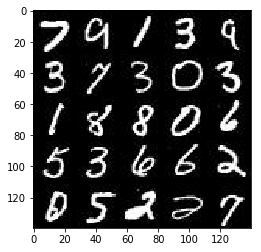

In [8]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

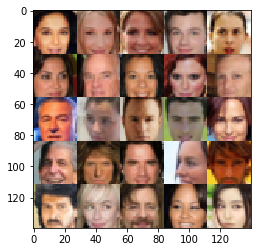

In [9]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [11]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [12]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.9)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.9)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.9)

        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [13]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)

        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.5)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.5)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.5)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
       
        out = tf.tanh(logits) 
   
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [14]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    images_count, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Change the range from (-0.5, 0.5) to (-1, 1) to be consistent with batch_z
                batch_images *= 2
                #print("Min/Max: {} / {}".format(np.min(batch_images), np.max(batch_images)))
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % 10 == 0:
                    # Get the losses and print them out after each 10 steps
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5139... Generator Loss: 9.7405
Epoch 1/2... Discriminator Loss: 0.4787... Generator Loss: 3.4882
Epoch 1/2... Discriminator Loss: 0.3799... Generator Loss: 7.1727
Epoch 1/2... Discriminator Loss: 1.0502... Generator Loss: 2.5485
Epoch 1/2... Discriminator Loss: 0.8713... Generator Loss: 1.1564
Epoch 1/2... Discriminator Loss: 0.8506... Generator Loss: 3.3629
Epoch 1/2... Discriminator Loss: 0.8560... Generator Loss: 1.4141
Epoch 1/2... Discriminator Loss: 1.1912... Generator Loss: 2.4183
Epoch 1/2... Discriminator Loss: 0.9441... Generator Loss: 1.3025
Epoch 1/2... Discriminator Loss: 1.0949... Generator Loss: 1.3716


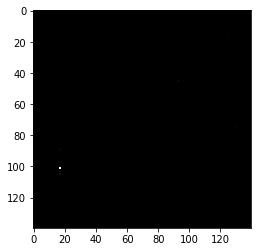

Epoch 1/2... Discriminator Loss: 1.1204... Generator Loss: 1.0443
Epoch 1/2... Discriminator Loss: 1.3203... Generator Loss: 2.6862
Epoch 1/2... Discriminator Loss: 0.8754... Generator Loss: 1.5196
Epoch 1/2... Discriminator Loss: 1.2463... Generator Loss: 0.6952
Epoch 1/2... Discriminator Loss: 1.0061... Generator Loss: 1.1888
Epoch 1/2... Discriminator Loss: 0.8833... Generator Loss: 1.1681
Epoch 1/2... Discriminator Loss: 1.0025... Generator Loss: 1.2417
Epoch 1/2... Discriminator Loss: 1.0071... Generator Loss: 2.0042
Epoch 1/2... Discriminator Loss: 0.8153... Generator Loss: 2.1767
Epoch 1/2... Discriminator Loss: 0.6100... Generator Loss: 2.6374


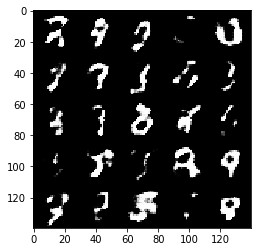

Epoch 1/2... Discriminator Loss: 1.4651... Generator Loss: 4.0265
Epoch 1/2... Discriminator Loss: 0.9044... Generator Loss: 2.3406
Epoch 1/2... Discriminator Loss: 0.9044... Generator Loss: 1.2586
Epoch 1/2... Discriminator Loss: 1.1575... Generator Loss: 1.2971
Epoch 1/2... Discriminator Loss: 1.2512... Generator Loss: 0.9687
Epoch 1/2... Discriminator Loss: 1.1331... Generator Loss: 0.7949
Epoch 1/2... Discriminator Loss: 1.2736... Generator Loss: 1.5062
Epoch 1/2... Discriminator Loss: 1.2428... Generator Loss: 0.9393
Epoch 1/2... Discriminator Loss: 1.0983... Generator Loss: 0.9379
Epoch 1/2... Discriminator Loss: 1.1432... Generator Loss: 1.1940


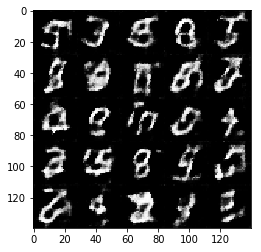

Epoch 1/2... Discriminator Loss: 1.1382... Generator Loss: 1.1090
Epoch 1/2... Discriminator Loss: 1.4997... Generator Loss: 0.5986
Epoch 1/2... Discriminator Loss: 1.1273... Generator Loss: 0.9095
Epoch 1/2... Discriminator Loss: 1.1600... Generator Loss: 0.9542
Epoch 1/2... Discriminator Loss: 1.1115... Generator Loss: 1.2552
Epoch 1/2... Discriminator Loss: 1.1612... Generator Loss: 1.0908
Epoch 1/2... Discriminator Loss: 1.1907... Generator Loss: 1.2133
Epoch 1/2... Discriminator Loss: 1.0516... Generator Loss: 1.4800
Epoch 1/2... Discriminator Loss: 1.2610... Generator Loss: 0.7135
Epoch 1/2... Discriminator Loss: 1.1695... Generator Loss: 0.7219


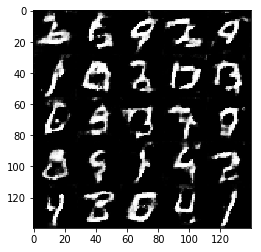

Epoch 1/2... Discriminator Loss: 1.0334... Generator Loss: 1.7116
Epoch 1/2... Discriminator Loss: 1.8949... Generator Loss: 3.0579
Epoch 1/2... Discriminator Loss: 1.0377... Generator Loss: 1.4019
Epoch 1/2... Discriminator Loss: 1.0950... Generator Loss: 1.0663
Epoch 1/2... Discriminator Loss: 1.0219... Generator Loss: 1.2528
Epoch 1/2... Discriminator Loss: 0.9119... Generator Loss: 1.6747
Epoch 1/2... Discriminator Loss: 1.0035... Generator Loss: 1.3731
Epoch 1/2... Discriminator Loss: 0.9153... Generator Loss: 1.4642
Epoch 1/2... Discriminator Loss: 1.1579... Generator Loss: 1.9363
Epoch 1/2... Discriminator Loss: 1.0576... Generator Loss: 1.5716


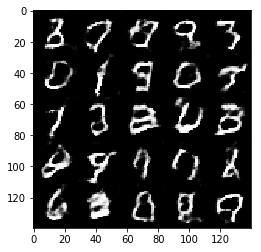

Epoch 1/2... Discriminator Loss: 1.0530... Generator Loss: 0.8218
Epoch 1/2... Discriminator Loss: 0.9048... Generator Loss: 1.1663
Epoch 1/2... Discriminator Loss: 0.9839... Generator Loss: 1.2001
Epoch 1/2... Discriminator Loss: 0.9390... Generator Loss: 1.0201
Epoch 1/2... Discriminator Loss: 1.1511... Generator Loss: 0.8316
Epoch 1/2... Discriminator Loss: 1.3115... Generator Loss: 0.7019
Epoch 1/2... Discriminator Loss: 1.0070... Generator Loss: 1.4314
Epoch 1/2... Discriminator Loss: 1.2674... Generator Loss: 0.7583
Epoch 1/2... Discriminator Loss: 2.0681... Generator Loss: 3.2568
Epoch 1/2... Discriminator Loss: 1.0587... Generator Loss: 0.8354


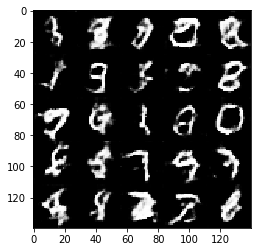

Epoch 1/2... Discriminator Loss: 0.8638... Generator Loss: 1.3236
Epoch 1/2... Discriminator Loss: 0.9568... Generator Loss: 2.2025
Epoch 1/2... Discriminator Loss: 1.0043... Generator Loss: 1.4289
Epoch 1/2... Discriminator Loss: 0.9702... Generator Loss: 1.0317
Epoch 1/2... Discriminator Loss: 0.8944... Generator Loss: 1.1924
Epoch 1/2... Discriminator Loss: 1.4435... Generator Loss: 2.7163
Epoch 1/2... Discriminator Loss: 0.9732... Generator Loss: 1.3531
Epoch 1/2... Discriminator Loss: 0.9724... Generator Loss: 1.3183
Epoch 1/2... Discriminator Loss: 1.2531... Generator Loss: 0.7014
Epoch 1/2... Discriminator Loss: 0.8438... Generator Loss: 1.1967


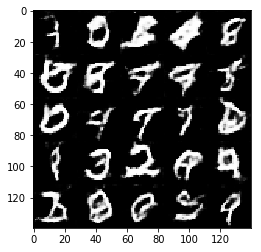

Epoch 1/2... Discriminator Loss: 0.8282... Generator Loss: 1.4802
Epoch 1/2... Discriminator Loss: 0.9641... Generator Loss: 0.9166
Epoch 1/2... Discriminator Loss: 0.7790... Generator Loss: 1.4519
Epoch 1/2... Discriminator Loss: 1.0919... Generator Loss: 2.1602
Epoch 1/2... Discriminator Loss: 0.8965... Generator Loss: 1.5849
Epoch 1/2... Discriminator Loss: 0.9453... Generator Loss: 2.2969
Epoch 1/2... Discriminator Loss: 0.8375... Generator Loss: 1.1124
Epoch 1/2... Discriminator Loss: 0.8890... Generator Loss: 2.2946
Epoch 1/2... Discriminator Loss: 0.7978... Generator Loss: 1.5990
Epoch 1/2... Discriminator Loss: 1.0546... Generator Loss: 1.3740


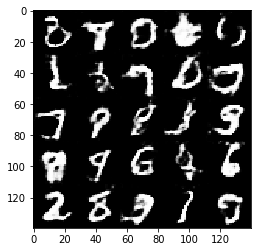

Epoch 1/2... Discriminator Loss: 1.1021... Generator Loss: 1.9942
Epoch 1/2... Discriminator Loss: 0.8669... Generator Loss: 1.6995
Epoch 1/2... Discriminator Loss: 0.9447... Generator Loss: 1.7812
Epoch 1/2... Discriminator Loss: 0.9542... Generator Loss: 1.8309
Epoch 1/2... Discriminator Loss: 0.7090... Generator Loss: 1.7942
Epoch 1/2... Discriminator Loss: 0.8913... Generator Loss: 1.4472
Epoch 1/2... Discriminator Loss: 1.2612... Generator Loss: 0.6503
Epoch 1/2... Discriminator Loss: 0.9022... Generator Loss: 1.3369
Epoch 1/2... Discriminator Loss: 1.1158... Generator Loss: 2.7084
Epoch 1/2... Discriminator Loss: 0.8392... Generator Loss: 1.7206


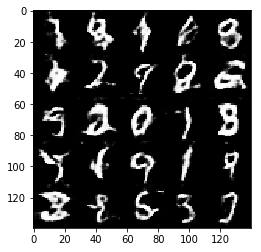

Epoch 1/2... Discriminator Loss: 0.8210... Generator Loss: 1.7695
Epoch 1/2... Discriminator Loss: 0.9374... Generator Loss: 1.1138
Epoch 1/2... Discriminator Loss: 0.8392... Generator Loss: 1.3628
Epoch 2/2... Discriminator Loss: 0.6950... Generator Loss: 2.1310
Epoch 2/2... Discriminator Loss: 0.7244... Generator Loss: 1.6419
Epoch 2/2... Discriminator Loss: 0.6334... Generator Loss: 2.3837
Epoch 2/2... Discriminator Loss: 0.9869... Generator Loss: 0.7732
Epoch 2/2... Discriminator Loss: 0.8832... Generator Loss: 1.2335
Epoch 2/2... Discriminator Loss: 0.8712... Generator Loss: 1.5667
Epoch 2/2... Discriminator Loss: 0.6920... Generator Loss: 1.7896


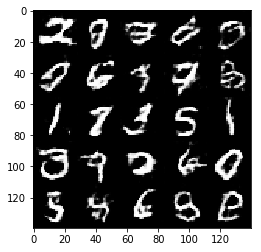

Epoch 2/2... Discriminator Loss: 0.8235... Generator Loss: 2.0441
Epoch 2/2... Discriminator Loss: 0.8585... Generator Loss: 1.7536
Epoch 2/2... Discriminator Loss: 1.0662... Generator Loss: 1.0501
Epoch 2/2... Discriminator Loss: 0.9364... Generator Loss: 1.1654
Epoch 2/2... Discriminator Loss: 1.1556... Generator Loss: 0.8203
Epoch 2/2... Discriminator Loss: 0.7906... Generator Loss: 1.6121
Epoch 2/2... Discriminator Loss: 0.9449... Generator Loss: 1.2457
Epoch 2/2... Discriminator Loss: 0.6068... Generator Loss: 2.1903
Epoch 2/2... Discriminator Loss: 1.0710... Generator Loss: 1.0153
Epoch 2/2... Discriminator Loss: 0.9191... Generator Loss: 1.3833


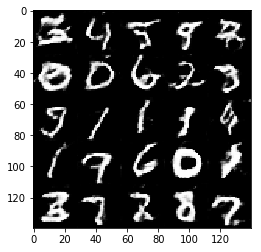

Epoch 2/2... Discriminator Loss: 0.7595... Generator Loss: 1.5514
Epoch 2/2... Discriminator Loss: 0.7349... Generator Loss: 1.8379
Epoch 2/2... Discriminator Loss: 1.1393... Generator Loss: 0.7852
Epoch 2/2... Discriminator Loss: 0.7502... Generator Loss: 2.6843
Epoch 2/2... Discriminator Loss: 1.0101... Generator Loss: 2.2819
Epoch 2/2... Discriminator Loss: 0.9544... Generator Loss: 2.9532
Epoch 2/2... Discriminator Loss: 0.7859... Generator Loss: 1.5923
Epoch 2/2... Discriminator Loss: 0.9170... Generator Loss: 1.5744
Epoch 2/2... Discriminator Loss: 0.9780... Generator Loss: 1.1002
Epoch 2/2... Discriminator Loss: 0.7589... Generator Loss: 1.6191


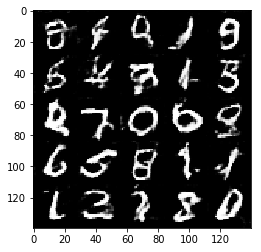

Epoch 2/2... Discriminator Loss: 1.0744... Generator Loss: 2.9245
Epoch 2/2... Discriminator Loss: 0.8601... Generator Loss: 1.2110
Epoch 2/2... Discriminator Loss: 0.9080... Generator Loss: 2.1618
Epoch 2/2... Discriminator Loss: 0.6321... Generator Loss: 2.4478
Epoch 2/2... Discriminator Loss: 0.8023... Generator Loss: 1.7648
Epoch 2/2... Discriminator Loss: 0.9995... Generator Loss: 2.2172
Epoch 2/2... Discriminator Loss: 0.8883... Generator Loss: 1.3522
Epoch 2/2... Discriminator Loss: 0.8638... Generator Loss: 1.1656
Epoch 2/2... Discriminator Loss: 0.8594... Generator Loss: 1.4832
Epoch 2/2... Discriminator Loss: 0.7808... Generator Loss: 1.5054


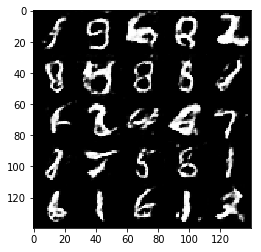

Epoch 2/2... Discriminator Loss: 0.7443... Generator Loss: 1.9308
Epoch 2/2... Discriminator Loss: 0.7314... Generator Loss: 1.5933
Epoch 2/2... Discriminator Loss: 0.6907... Generator Loss: 2.0690
Epoch 2/2... Discriminator Loss: 0.7156... Generator Loss: 1.8987
Epoch 2/2... Discriminator Loss: 0.7200... Generator Loss: 1.6433
Epoch 2/2... Discriminator Loss: 0.9781... Generator Loss: 1.0467
Epoch 2/2... Discriminator Loss: 0.7222... Generator Loss: 1.6999
Epoch 2/2... Discriminator Loss: 0.7336... Generator Loss: 2.3830
Epoch 2/2... Discriminator Loss: 0.6338... Generator Loss: 2.1201
Epoch 2/2... Discriminator Loss: 1.0184... Generator Loss: 2.7535


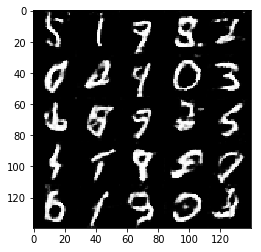

Epoch 2/2... Discriminator Loss: 0.8639... Generator Loss: 3.4296
Epoch 2/2... Discriminator Loss: 0.6350... Generator Loss: 2.1561
Epoch 2/2... Discriminator Loss: 0.7392... Generator Loss: 1.1310
Epoch 2/2... Discriminator Loss: 0.5937... Generator Loss: 2.1595
Epoch 2/2... Discriminator Loss: 0.7912... Generator Loss: 1.2789
Epoch 2/2... Discriminator Loss: 0.6157... Generator Loss: 2.3905
Epoch 2/2... Discriminator Loss: 0.6528... Generator Loss: 2.6918
Epoch 2/2... Discriminator Loss: 1.1043... Generator Loss: 3.0511
Epoch 2/2... Discriminator Loss: 0.7698... Generator Loss: 1.6551
Epoch 2/2... Discriminator Loss: 0.6757... Generator Loss: 2.9593


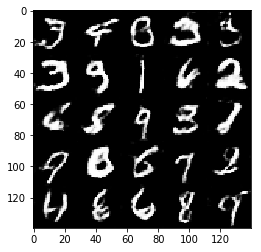

Epoch 2/2... Discriminator Loss: 1.0037... Generator Loss: 1.0959
Epoch 2/2... Discriminator Loss: 0.5985... Generator Loss: 2.0775
Epoch 2/2... Discriminator Loss: 0.6903... Generator Loss: 1.7644
Epoch 2/2... Discriminator Loss: 0.8817... Generator Loss: 1.5640
Epoch 2/2... Discriminator Loss: 0.5530... Generator Loss: 2.0892
Epoch 2/2... Discriminator Loss: 0.7076... Generator Loss: 1.9238
Epoch 2/2... Discriminator Loss: 0.7172... Generator Loss: 1.8171
Epoch 2/2... Discriminator Loss: 0.5726... Generator Loss: 3.0406
Epoch 2/2... Discriminator Loss: 1.2727... Generator Loss: 4.1602
Epoch 2/2... Discriminator Loss: 0.8442... Generator Loss: 1.4742


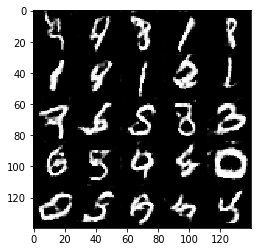

Epoch 2/2... Discriminator Loss: 1.1468... Generator Loss: 4.2935
Epoch 2/2... Discriminator Loss: 0.9077... Generator Loss: 1.6788
Epoch 2/2... Discriminator Loss: 0.6374... Generator Loss: 2.1272
Epoch 2/2... Discriminator Loss: 0.5418... Generator Loss: 2.3698
Epoch 2/2... Discriminator Loss: 0.6794... Generator Loss: 3.6590
Epoch 2/2... Discriminator Loss: 0.5633... Generator Loss: 2.8796
Epoch 2/2... Discriminator Loss: 0.5734... Generator Loss: 2.9080
Epoch 2/2... Discriminator Loss: 0.7821... Generator Loss: 2.4510
Epoch 2/2... Discriminator Loss: 0.5715... Generator Loss: 2.6492
Epoch 2/2... Discriminator Loss: 0.5331... Generator Loss: 2.2471


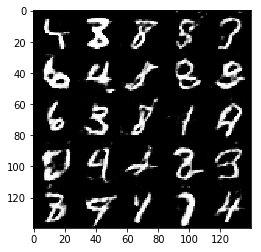

Epoch 2/2... Discriminator Loss: 0.5870... Generator Loss: 2.8478
Epoch 2/2... Discriminator Loss: 0.5428... Generator Loss: 2.7884
Epoch 2/2... Discriminator Loss: 0.6445... Generator Loss: 3.5856
Epoch 2/2... Discriminator Loss: 0.7065... Generator Loss: 2.0724
Epoch 2/2... Discriminator Loss: 0.6765... Generator Loss: 1.9971
Epoch 2/2... Discriminator Loss: 0.5704... Generator Loss: 2.6723
Epoch 2/2... Discriminator Loss: 0.4947... Generator Loss: 2.6751
Epoch 2/2... Discriminator Loss: 0.6051... Generator Loss: 3.5339
Epoch 2/2... Discriminator Loss: 1.1359... Generator Loss: 1.2037
Epoch 2/2... Discriminator Loss: 1.0614... Generator Loss: 1.0631


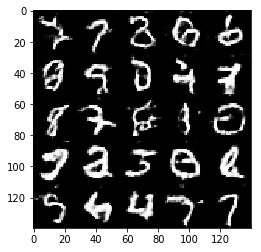

Epoch 2/2... Discriminator Loss: 0.7010... Generator Loss: 1.9588
Epoch 2/2... Discriminator Loss: 0.5347... Generator Loss: 2.1199
Epoch 2/2... Discriminator Loss: 0.8320... Generator Loss: 3.6266
Epoch 2/2... Discriminator Loss: 0.6888... Generator Loss: 1.6668
Epoch 2/2... Discriminator Loss: 0.7384... Generator Loss: 3.7120
Epoch 2/2... Discriminator Loss: 0.5357... Generator Loss: 2.5625
Epoch 2/2... Discriminator Loss: 0.5253... Generator Loss: 2.4042


In [26]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.0519... Generator Loss: 0.3954
Epoch 1/1... Discriminator Loss: 0.8785... Generator Loss: 1.9804
Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 2.2389
Epoch 1/1... Discriminator Loss: 0.7678... Generator Loss: 2.1326
Epoch 1/1... Discriminator Loss: 0.7344... Generator Loss: 3.2553
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 1.0174
Epoch 1/1... Discriminator Loss: 0.5381... Generator Loss: 2.5143
Epoch 1/1... Discriminator Loss: 0.6004... Generator Loss: 3.7969
Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 3.3624
Epoch 1/1... Discriminator Loss: 0.4072... Generator Loss: 4.5496


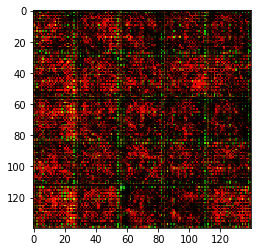

Epoch 1/1... Discriminator Loss: 0.3649... Generator Loss: 5.2320
Epoch 1/1... Discriminator Loss: 0.4029... Generator Loss: 3.7383
Epoch 1/1... Discriminator Loss: 0.3844... Generator Loss: 4.1331
Epoch 1/1... Discriminator Loss: 2.3604... Generator Loss: 0.3334
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 0.8284... Generator Loss: 1.3995
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 0.8379... Generator Loss: 1.7253
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 3.6888... Generator Loss: 4.1443


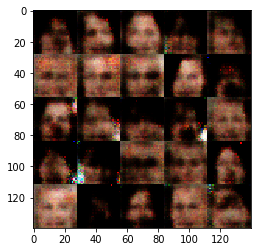

Epoch 1/1... Discriminator Loss: 0.7861... Generator Loss: 1.4635
Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 1.2003
Epoch 1/1... Discriminator Loss: 0.8104... Generator Loss: 1.2428
Epoch 1/1... Discriminator Loss: 0.7881... Generator Loss: 1.6036
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 1.7478
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 3.0055
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 1.4297
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 2.1476


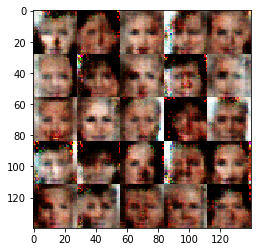

Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 1.0853
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.9960
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.4679
Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 1.6674
Epoch 1/1... Discriminator Loss: 1.0125... Generator Loss: 1.3328
Epoch 1/1... Discriminator Loss: 0.9213... Generator Loss: 1.2580


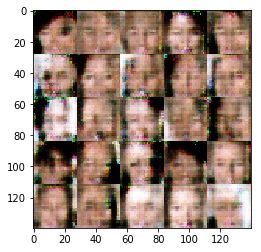

Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 1.4606
Epoch 1/1... Discriminator Loss: 3.7517... Generator Loss: 3.9458
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 0.9912
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 1.2916
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 1.2861
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.5354... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 1.0309


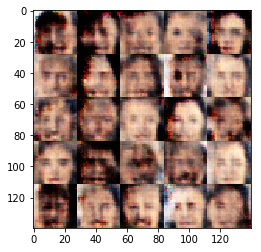

Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 0.9282... Generator Loss: 1.0349
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 1.8532
Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 1.0754
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 1.8458
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 0.9481
Epoch 1/1... Discriminator Loss: 1.7321... Generator Loss: 2.8027


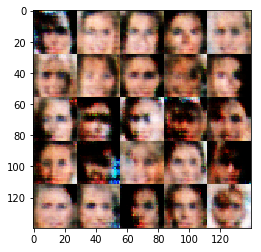

Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 0.9543... Generator Loss: 1.1522
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 1.0339
Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.8111


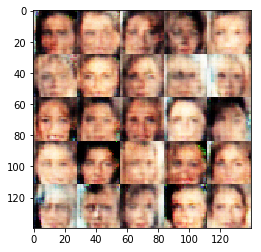

Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.8894
Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 0.4584
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 2.1243
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 1.1514
Epoch 1/1... Discriminator Loss: 1.6944... Generator Loss: 2.2076
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.5304


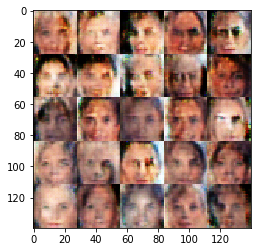

Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.9638
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 1.7783
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 1.3470
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 1.9090
Epoch 1/1... Discriminator Loss: 1.5611... Generator Loss: 0.4290
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 2.2315


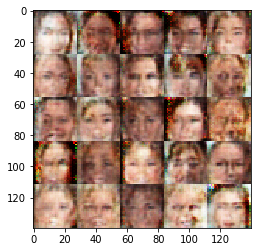

Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 1.1445
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 1.3149
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 0.9898... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 1.1937
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 1.0734
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.9888


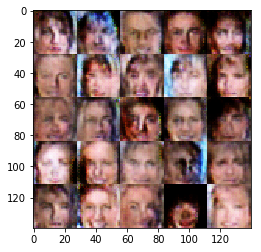

Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.4283
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 1.0441
Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.9762
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 1.0626


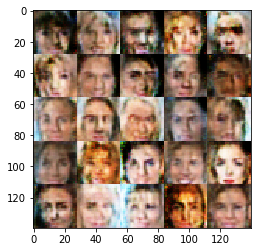

Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 1.0711
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 1.7436
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 1.1360
Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 1.2047
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 1.1605
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.9674
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.8448


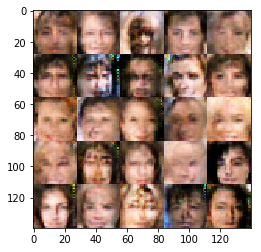

Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 1.0915
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 1.2326
Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 1.1588
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 1.3613
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 1.1423
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.9408
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.9670
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 1.0358
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.9956


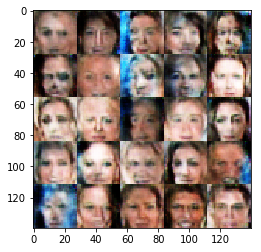

Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 1.0664
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 0.9076
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 1.3290
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 1.0911
Epoch 1/1... Discriminator Loss: 1.5658... Generator Loss: 0.4748
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.9671
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.9797
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.8510


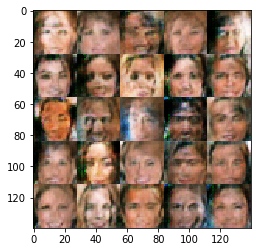

Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 1.1805
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 1.0909
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.8753


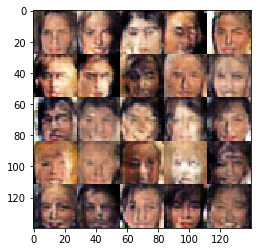

Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.9624
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 1.1187
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 1.0686
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 1.2644
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 1.0343
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.5675
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.9604


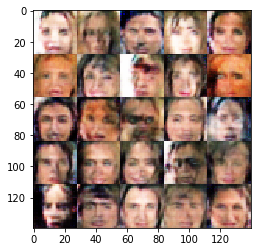

Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 1.2082
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 1.0460
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 1.0102
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.1767... Generator Loss: 1.0990
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.5888


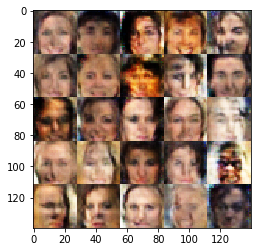

Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 1.1326
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 1.3515
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 1.2579
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 1.0486
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 1.0325
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 1.0461


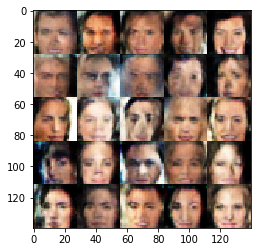

Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 1.1561
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 1.8312
Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 1.0724
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 1.3916
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 1.1579


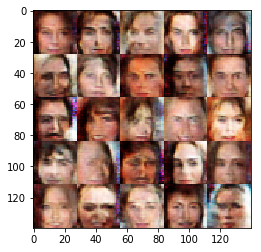

Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.5147
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 1.1029
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.8909
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 1.6966
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 1.2560
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 1.1334


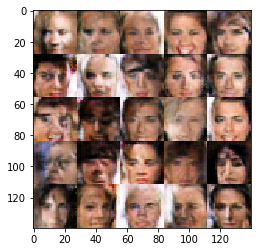

Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 1.4385
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 1.0201
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.9878
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 1.1605
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 1.4403


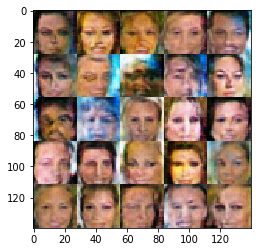

Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.9834
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 1.0153
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 1.1883
Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 1.1337
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.9313
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.6876


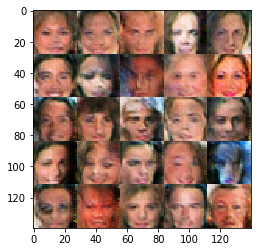

Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 1.1457
Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 1.0820
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 1.5212
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 1.0826
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 1.1702
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.7753


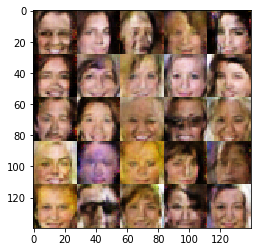

Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 1.0510
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 1.1469
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 1.1881
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 0.9464
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.6792


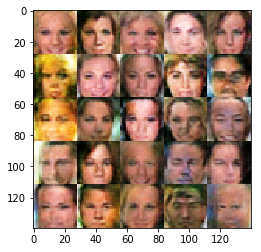

Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 1.2568
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.9702
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.9095
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.5632
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 1.8684
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 1.2359
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 1.7534


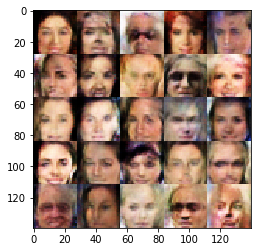

Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.9453
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 1.4695
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.9954
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 1.0578
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 1.2215


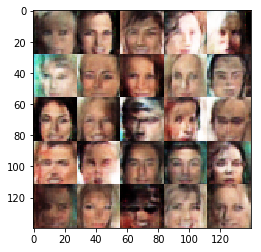

Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 1.1585
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 1.0564
Epoch 1/1... Discriminator Loss: 1.5136... Generator Loss: 0.5134
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 1.5947
Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 1.1263
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 1.3921
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 1.5095


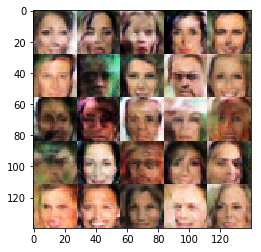

Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 1.0710
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 1.1476
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.5289
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 1.3471


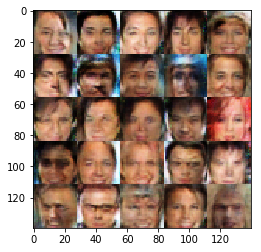

Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 1.1883
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 0.9803
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 1.2587
Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 1.0768
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.9699


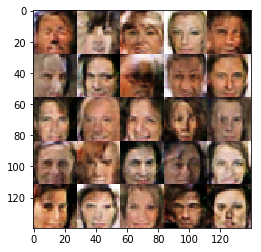

Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.9069
Epoch 1/1... Discriminator Loss: 1.0851... Generator Loss: 1.3062
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 1.1394
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 1.8093
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 1.4330
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 1.0582
Epoch 1/1... Discriminator Loss: 1.0562... Generator Loss: 1.1882


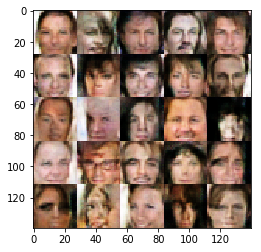

Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 0.9424... Generator Loss: 1.1594
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 1.7779
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 1.3557
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.9805
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.6656


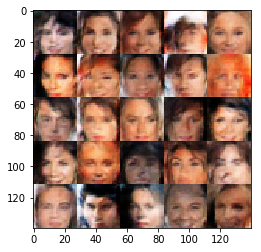

Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 1.4520
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 0.9138
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.9838
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.6395


In [27]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.